In [44]:
!git clone https://github.com/rslim087a/track.git

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 33.88 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [47]:
!ls


data  data_old	sample_data


In [48]:

!pip3 install imgaug

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.image as mpimg
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath
import os
from imgaug import augmenters as iaa

In [50]:
datadir = '/content/data/'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [51]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

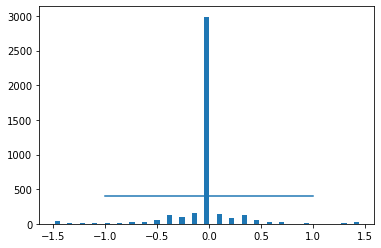

In [52]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1])+bins[1:] * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [53]:

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

2590
1463


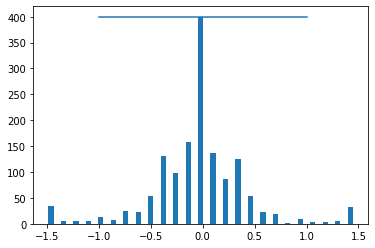

In [54]:
print(len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print(len(data))
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [55]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_path, steering
image_paths, steerings = load_img_steering(datadir+'/IMG', data)

center      center_2018_07_16_17_11_44_485.jpg
left        left_2018_07_16_17_11_44_485.jpg  
right       right_2018_07_16_17_11_44_485.jpg 
steering   -0.25                              
throttle    0.863326                          
reverse     0                                 
speed       2.17305                           
Name: 13, dtype: object


Text(0.5, 1.0, 'Validation set')

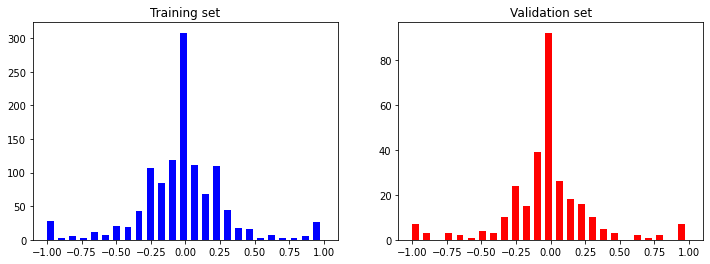

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')

axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [57]:
"""
design our own data image generator. We used the image data generator provided by keras, however designing our own generator provides us with added flexibility as.it allows you to add or remove any of the augmentation techniques that you require
"""
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

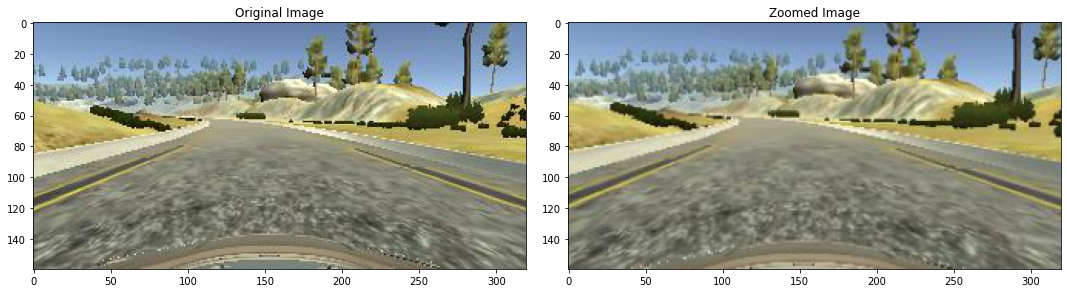

In [58]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed Image')

In [62]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

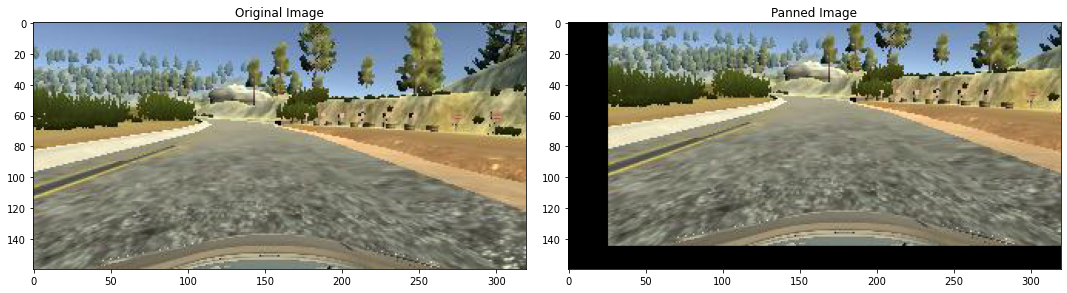

In [63]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')

In [64]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness altered Image')

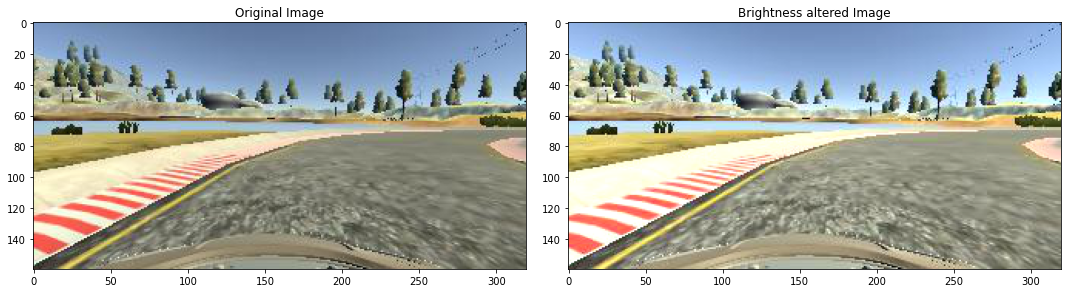

In [65]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
bright_image = img_random_brightness(original_image)
fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(bright_image)
axes[1].set_title('Brightness altered Image')

In [66]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.25')

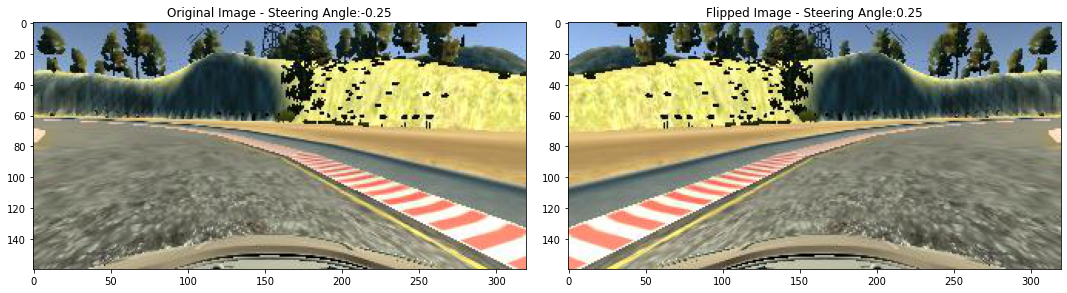

In [67]:
rand_index = random.randint(0, 1000)
steering = steerings[rand_index]
image = image_paths[rand_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering = img_random_flip(original_image, steering)
fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering))
axes[1].imshow(flipped_image)
axes[1].set_title('Flipped Image - '+ 'Steering Angle:' + str(flipped_steering))

In [68]:
def img_preprocess(img):
  # img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img / 255 #normalizing
  return img

In [69]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

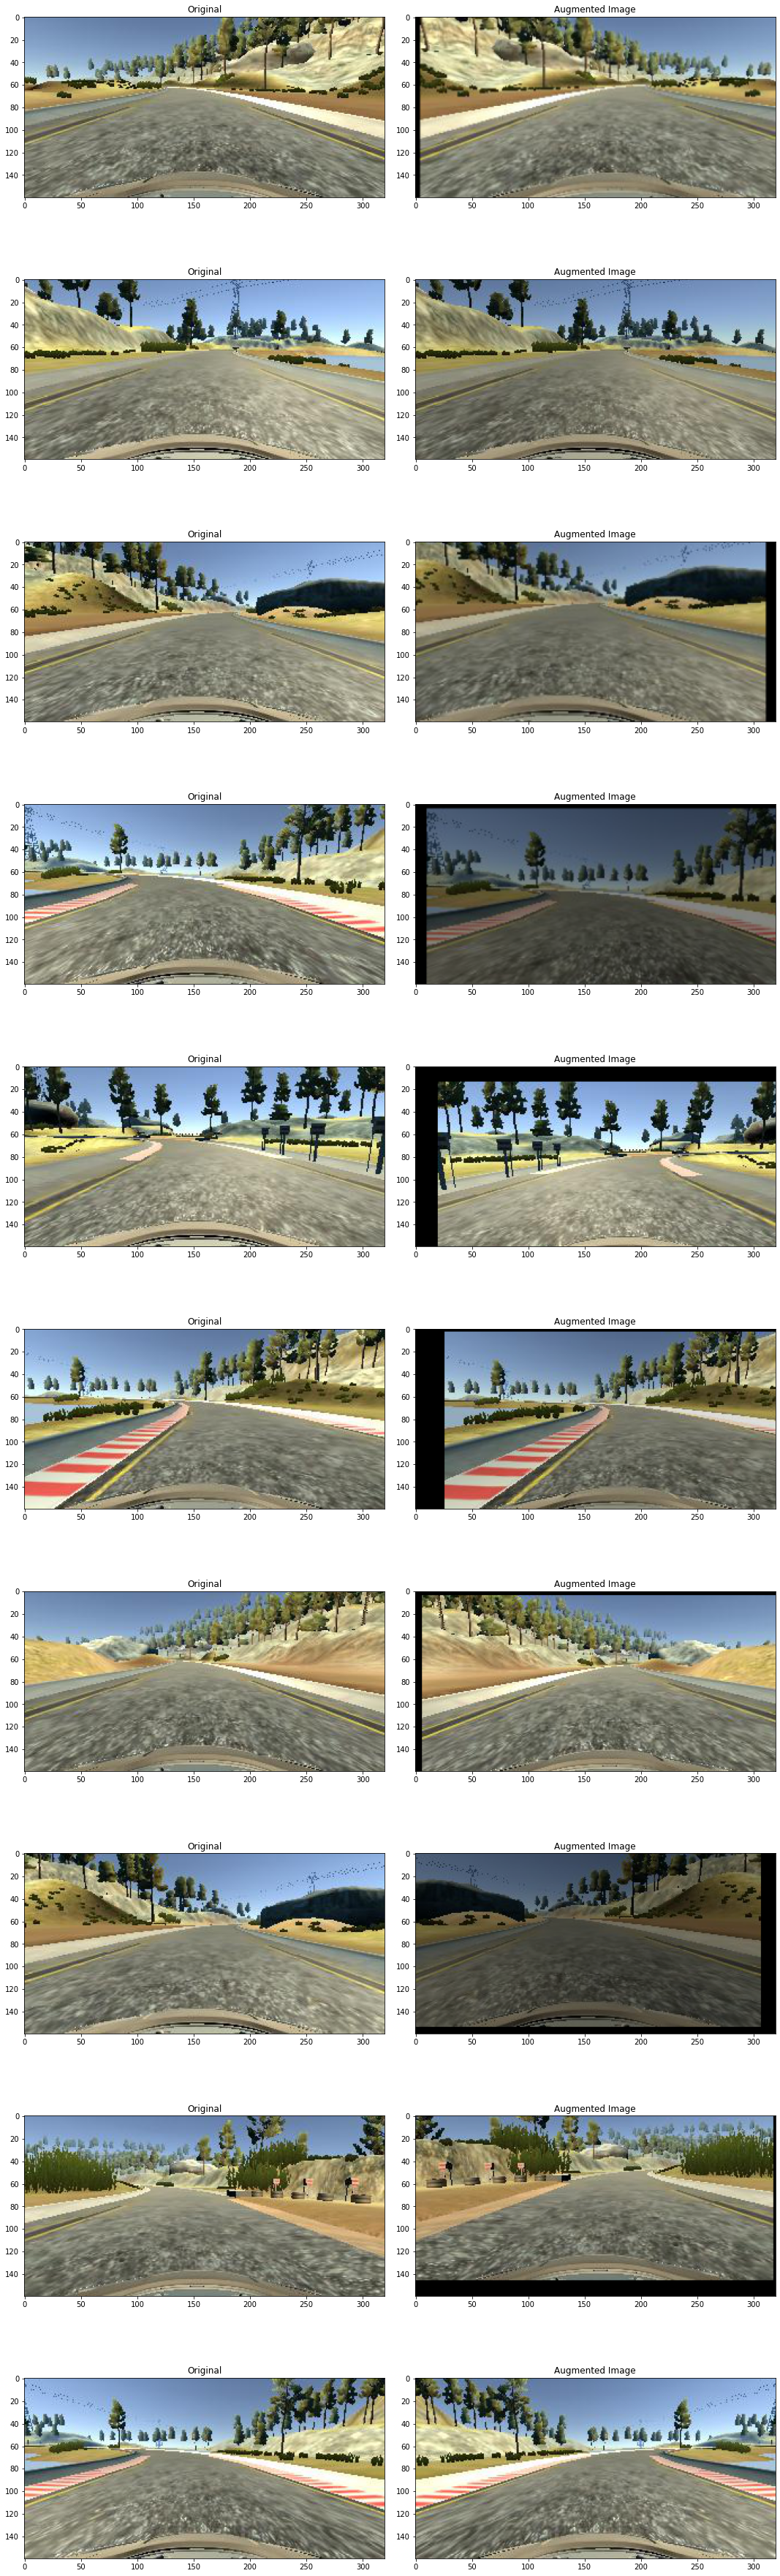

In [70]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()
for i in range(10):
  rand = random.randint(0, len(image_paths) - 1)
  rand_img = image_paths[rand]
  rand_steer = steerings[rand]
  original_image = mpimg.imread(rand_img)
  augment_image, steering = random_augment(rand_img, rand_steer)
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original')
  axs[i][1].imshow(augment_image)
  axs[i][1].set_title('Augmented Image')

Text(0.5, 1.0, 'Validation Image')

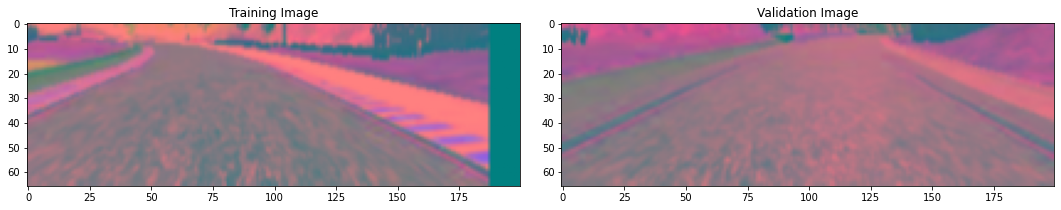

In [71]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [72]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[1].imshow(preprocessed_image)

TypeError: ignored

In [ ]:
# #prepross training data
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))


TypeError: ignored

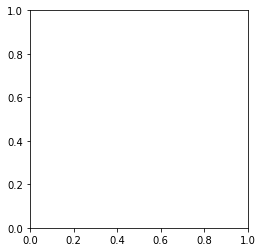

In [73]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [74]:
def nvidia_model():
 
  model = Sequential()
  
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
  
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  # model.add(Dropout(0.5))
  
  
  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))
  
  
  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(1))
  
  
  optimizer= Adam(learning_rate=1e-5)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model


In [75]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)              

In [76]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),  steps_per_epoch=300,epochs=10, 
                              validation_data = batch_generator(X_valid, y_valid, 100,0), validation_steps=200, verbose=1, shuffle=1)

Epoch 1/10
300/300 [==============================] - 178s 594ms/step - loss: 0.0988 - val_loss: 0.0904
Epoch 2/10
300/300 [==============================] - 177s 592ms/step - loss: 0.0967 - val_loss: 0.0842
Epoch 3/10
300/300 [==============================] - 177s 591ms/step - loss: 0.0822 - val_loss: 0.0635
Epoch 4/10
300/300 [==============================] - 178s 596ms/step - loss: 0.0733 - val_loss: 0.0611
Epoch 5/10
300/300 [==============================] - 178s 596ms/step - loss: 0.0680 - val_loss: 0.0596
Epoch 6/10
300/300 [==============================] - 177s 593ms/step - loss: 0.0637 - val_loss: 0.0587
Epoch 7/10
300/300 [==============================] - 177s 592ms/step - loss: 0.0616 - val_loss: 0.0587
Epoch 8/10
300/300 [==============================] - 177s 591ms/step - loss: 0.0618 - val_loss: 0.0576
Epoch 9/10
300/300 [==============================] - 177s 591ms/step - loss: 0.0613 - val_loss: 0.0550
Epoch 10/10
300/300 [==============================] - 177s 592m

Text(0.5, 1.0, 'loss')

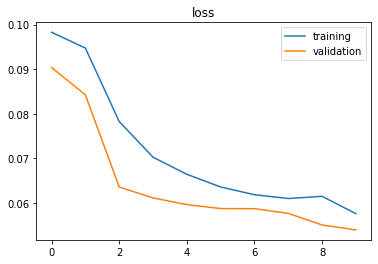

In [77]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')


In [78]:
model.save('model.h5')

In [41]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>